Author: Sandijs Vasilevskis, savas20@student.sdu.dk

Date: 28-05-2021

In [1]:
from datetime import datetime
import time
import string
import re
import os
import glob
import json
import gzip

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

from collections import Counter

# Downloading the dataset
For the purposes of this project articles from 2019 until now are used. Note that the articles are sorted by the date they appeared on the front pages of news outlets so the article itself can be somewhat older and there will be article duplicates across time-stamps (one article could have stayed on front page for a bit).
- Article data is described here: http://sciride.org/news.html
- The processed articles are available here: https://news-mine.s3.eu-west-2.amazonaws.com/processed.tar.gz
- With documentation here: http://sciride.org/news.html#datacontent

# Preprocessing Data
- Filtering articles by news outlet domain name, language and dates
- Tagging articles related to COVID-19
- Prepare training and test datasets
- Tokenization of the article description field (from text to sentences to words), remove punctuation and English stopwords
- Normalization of the tokenized text (stemming, lemmatization)

In [2]:
def filter_articles(domain_name='bbc.com', date_from='2019-01-01', date_to='2021-01-01'):
    """This function retrieves the list of file paths from mayor online news outlets dataset.
    These processed articles can be downloaded here: 
        https://news-mine.s3.eu-west-2.amazonaws.com/processed.tar.gz
    N.B.:
        This function can be used assuming that the compressed file from the link above is downloaded and
        extracted under the 'release' folder and ontains all the news domain subfolders. 
        Otherwise the file path in function glob.glob() can be altered.
    Args:   
        domain_name (str): Subfolder name of the specific online news outlet i.e. 'bbc.com'
        date_from (str): Start date string i.e.'2019-01-01'
        date_to (str): End date string i.e.'2021-01-01'
    Returns:
        file_paths (list): File paths from the selected news article domain and corresponding time period.
    """
    date_from = datetime.strptime(date_from, "%Y-%m-%d")
    date_to = datetime.strptime(date_to, "%Y-%m-%d")
    
    file_paths = []
    for file_name in glob.glob(f'release\\{domain_name}\\per_day\\*.gz'):
        dt_string = os.path.basename(file_name).split('.')[0]
        dt_object = datetime.strptime(dt_string, "%Y%m%d")
    
        if date_to >= dt_object >= date_from:            
            file_path = os.path.join(os.getcwd(), file_name)
            file_paths.append(file_path)
            
    return file_paths   
      
print(filter_articles()[:5])

['C:\\Files\\SDU Data Science [2020]\\SDU [2021]\\DM882 Text Mining\\Project\\release\\bbc.com\\per_day\\20190101.gz',
 'C:\\Files\\SDU Data Science [2020]\\SDU [2021]\\DM882 Text Mining\\Project\\release\\bbc.com\\per_day\\20190102.gz',
 'C:\\Files\\SDU Data Science [2020]\\SDU [2021]\\DM882 Text Mining\\Project\\release\\bbc.com\\per_day\\20190103.gz',
 'C:\\Files\\SDU Data Science [2020]\\SDU [2021]\\DM882 Text Mining\\Project\\release\\bbc.com\\per_day\\20190104.gz',
 'C:\\Files\\SDU Data Science [2020]\\SDU [2021]\\DM882 Text Mining\\Project\\release\\bbc.com\\per_day\\20190105.gz']

### Combine all filepaths from available news outlets

In [3]:
# Read .json file with domain names and outlet language
file = open('available_outlets.json', 'r', encoding='utf-8')
outlets = json.loads(file.read())

# Filter news outlets written in English only
outlets_en = {}
for k, v in outlets.items():    
    if v['lng'][0] == 'en':        
        outlets_en[k] = {'country': v['country']}
        
# List of domain names to iterate over
domain_names = list(outlets_en.keys())

# Collect all file paths (2019 - 2020)
file_paths = []
for domain_name in domain_names:    
    file_paths.extend(filter_articles(domain_name, date_from='2019-01-01', date_to='2021-01-01'))
    
print(len(file_paths))
print(file_paths[:5])

55160
['C:\\Files\\SDU Data Science [2020]\\SDU [2021]\\DM882 Text Mining\\Project\\release\\9news.com.au\\per_day\\20190101.gz', 'C:\\Files\\SDU Data Science [2020]\\SDU [2021]\\DM882 Text Mining\\Project\\release\\9news.com.au\\per_day\\20190102.gz', 'C:\\Files\\SDU Data Science [2020]\\SDU [2021]\\DM882 Text Mining\\Project\\release\\9news.com.au\\per_day\\20190103.gz', 'C:\\Files\\SDU Data Science [2020]\\SDU [2021]\\DM882 Text Mining\\Project\\release\\9news.com.au\\per_day\\20190104.gz', 'C:\\Files\\SDU Data Science [2020]\\SDU [2021]\\DM882 Text Mining\\Project\\release\\9news.com.au\\per_day\\20190105.gz']


### Tagging articles related to COVID-19 

In [4]:
def tag_covid19(text):
    """This function uses regular expressions to identify if the text is COVID-19 related or not.
     """
    # Note that '-' is replaced with ' ' to shorten the synonym list
    text = text.replace('-', ' ')
    
    # COVID-19 related keywords
    covid19_synonyms_list = ['covid',
                             r'covid(.*?)19',                             
                             'coronavirus disease 19',
                             r'severe acute respiratory syndrome coronavirus(.*?)2',                             
                             r'sars(.*?)cov(.*?)2',                          
                             r'2019(.*?)n(.*?)cov',                     
                             r'n(.*?)cov(.*?)2019',
                             'coronavirus',
                             'coronavirus 2019',
                             'wuhan pneumonia',
                             'wuhan virus',
                             'wuhan coronavirus',
                             r'coronavirus(.*?)2',
                            'lockdown', 'quarantine', 'pandemic'
                            ]
    # ignore casing
    if re.compile('|'.join(covid19_synonyms_list), re.IGNORECASE).search(text):            
        return True
    else:
        return False
    
tag_covid19('This text is about covid-19')

True

In [5]:
def extract_article_data(file_path):
    """This function reads the relevant information zipped article files from the file path.
    """
    dt_string = os.path.basename(file_path).split('.')[0]
    dt_object = datetime.strptime(dt_string, "%Y%m%d")
    
    d = json.load(gzip.open(file_path))
    
    article_list = []
    
    for article_id, article_dict in d.items():        
        dct = {'article_id': article_id, 
               'title': article_dict['title'], 
               'description': article_dict['description'], 
               'date': dt_object}
        dct['is_covid_tag'] = any([tag_covid19(article_dict['description']), tag_covid19(article_dict['title'])])
        dct['is_covid'] = article_dict['is_covid']
        article_list.append(dct)
        
    # Remove duplicated articles    
    df = pd.DataFrame(article_list).drop_duplicates()
    return df
    
df = extract_article_data(filter_articles()[-1])
df.head()

,article_id,title,description,date,is_covid_tag,is_covid
0,cd06a6b02378991447309a60ed27bc9c,US election 2020: The young people struggling ...,How the pandemic is changing the economic pros...,2020-10-17,True,True
1,e0ddb2d43e898d0cf212baef9963618f,BBC - Travel - The private language of Venice,Although many travellers assume that the “auth...,2020-10-17,False,False
2,6f0b26eaa2adf75b51edb1eb8fa0bbb4,The African lake with explosive power - BBC Fu...,In central Africa is a deep lake that has a da...,2020-10-17,False,False
3,2c5da074e2b70b2e9e1f6e7b0948cb97,Said Benrahma: West Ham sign Algeria winger fr...,West Ham sign Algeria winger Said Benrahma fro...,2020-10-17,False,False
4,336121e33d92e3fddeb2dad94d20098c,Salisbury Novichok-poisoned officer Nick Baile...,"Det Sgt Nick Bailey ""had to admit defeat"" afte...",2020-10-17,False,False


In [18]:
df.loc[df.is_covid==True]

,article_id,title,description,date,is_covid_tag,is_covid
79,8d09044ee04e6c92f89a97a18315274a,China's mystery SARS-like virus spreads to Japan,Fears are mounting across Asia over the cross-...,2020-01-16,True,True
53,7cd84a0cba91e97286902ccea4107f4c,China news: Efforts stepped up to contain coro...,China will step up efforts to contain the coro...,2020-01-19,True,True
10,d053a48177e970959342b3e29be8660a,Brisbane man tested for mystery virus - 9News,The chief medical officer says the risk posed ...,2020-01-20,True,True
25,64c4cdc3bcf1e872451a622d51a77860,New strain of deadly China coronavirus 'can be...,"Authorities in multiple countries, including C...",2020-01-20,True,True
49,7cd84a0cba91e97286902ccea4107f4c,China news: Efforts stepped up to contain coro...,China will step up efforts to contain the coro...,2020-01-20,True,True
...,...,...,...,...,...,...
218,50b85a555631589517863708b0ec7247,Coronavirus in Ireland - All household visits ...,ALL household visits have been banned in a bid...,2020-10-15,True,True
226,c977a29a7b78c851a499e102128bcedb,Khloe Kardashian mocked for boasting about loo...,KHLOE Kardashian has been mocked for boasting ...,2020-10-15,True,True
227,5782e4fe7474d84dfb13a9a39c7b43e5,Coronavirus in Ireland - Taoiseach Micheal Mar...,"DONEGAL, Cavan and Monaghan will be raised fro...",2020-10-15,True,True
253,6078d4ab83a04d942caef10152bfd0b8,Budget bonanza to see Govt try to build their ...,A CONSTRUCTION budget bonanza will see the ­Go...,2020-10-15,True,True


### Combine data from all available news outlets

In [6]:
start = time.time()

# Combine all news articles into a DataFrame
df_list = []
for file_path in file_paths:      
    try:
        df_list.append(extract_article_data(file_path))
    except:
        continue
    
df = pd.concat(df_list)

end = time.time()
print(f'Time to extract data: {round((end - start)/ 60, 1)} minutes')

df.info()

2265.308422088623
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9519797 entries, 0 to 265
Data columns (total 6 columns):
 #   Column        Dtype         
---  ------        -----         
 0   article_id    object        
 1   title         object        
 2   description   object        
 3   date          datetime64[ns]
 4   is_covid_tag  bool          
 5   is_covid      bool          
dtypes: bool(2), datetime64[ns](1), object(3)
memory usage: 381.3+ MB


## Training and Test Datasets
Split the dataset - 80% for training and 20% for testing the classifier.

### Training data
Hint: picking articles with COVID-19 keyword in titles/descriptions would seed your training set of ‘positive’ articles whereas 2019 articles can be taken as
the ‘negative’ set.

In [34]:
# Selecting article description text
X, y = df.description, df.is_covid
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
# Summarize
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (7615837,) (7615837,)
Test (1903960,) (1903960,)


In [39]:
# Check the class balance after splitting data
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

False    0.885345
True     0.114655
Name: is_covid, dtype: float64
False    0.885622
True     0.114378
Name: is_covid, dtype: float64


## Naive Bayes Text Classifier
Creating a classifier based on news article title or description to determine whether the article is about COVID-19 or not. Estimating formally the performance of the classifier using accuracy $$(TN + TP)/(TN + TP + FN + FP)$$

- Calculate Prior Probabilities for given class labels
- Calculate Conditional Probabilities with each attribute for each class
- Multiply same class Conditional Probability
- Multiply Prior probability with Step 3 probability
- Add Laplace smoothing to avoid zero probability for words that are not in training set
- To determine class, see which class has higher posterior probability

In [47]:
class TextNaiveBayes(object):
    """Implementation of Naive Bayes classifier for text binary classification."""
 
    def tokenize_text(self, text, remove_stopwords=True):
        """This function will tokenize text and remove stopwords.
        """
        word_tokens = []
        # Sentence tokenization
        sentences_nltk = sent_tokenize(text)        
        for sentence in sentences_nltk:
            # Remove punctuation
            sentence = sentence.translate(str.maketrans('', '', string.punctuation)).lower()
            # Word tokenization        
            tokens = [w for w in word_tokenize(sentence)]#if w.isalpha() # leave alphabetic characters only
            # Remove stopwords
            if remove_stopwords:
                no_stops = [t for t in tokens if t not in stopwords.words('english')]
                word_tokens.extend(no_stops)            
            else:
                word_tokens.extend(tokens)
        return word_tokens
    
    def normalize_text(self, word_tokens, lemmatize_words=False):
        """This function uses Snowball stemmer or WordNet lemmatizer to normalize words.
        """
        normalized_words = []   
        # Lemmatize words
        if lemmatize_words:        
            wordnet_lemmatizer = WordNetLemmatizer()
            for word in word_tokens:            
                normalized_words.append(wordnet_lemmatizer.lemmatize(word)) 
        # Stem words  
        else:
            snowball = SnowballStemmer('english')
            for word in word_tokens:            
                normalized_words.append(snowball.stem(word))           
        return normalized_words
 
    def get_word_counts(self, words):
        """This function returns a dictionary of word counts."""
        return dict(Counter(words))
    
    def fit(self, X_train, y_train):
        """This function calculates log class prior probabilities from the training data."""
        self.num_articles = {}
        self.log_class_priors = {}
        self.word_counts = {}
        self.vocab = set()

        n = len(X_train)
        self.num_articles['is_target'] = sum(1 for label in y_train if label == True)
        self.num_articles['not_target'] = sum(1 for label in y_train if label == False)
        self.log_class_priors['is_target'] = np.log(self.num_articles['is_target'] / n)
        self.log_class_priors['not_target'] = np.log(self.num_articles['not_target'] / n)
        self.word_counts['is_target'] = {}
        self.word_counts['not_target'] = {}

        for x, y in zip(X_train, y_train):
            c = 'is_target' if y else 'not_target'
            tokenized_text = self.tokenize_text(x)
            normalized_text = self.normalize_text(tokenized_text)
            counts = self.get_word_counts(normalized_text)

            for word, count in counts.items():
                if word not in self.vocab:
                    self.vocab.add(word)
                if word not in self.word_counts[c]:
                    self.word_counts[c][word] = 0.0

                self.word_counts[c][word] += count
    
    def predict(self, X_test):
        """This function uses Naive Bayes calculation to return a list of predicted class labels."""
        result = []
        for x in X_test:
            tokenized_text = self.tokenize_text(x)
            normalized_text = self.normalize_text(tokenized_text)
            counts = self.get_word_counts(normalized_text)
            is_target_score = 0
            not_target_score = 0
            
            for word, _ in counts.items():
                # Add Laplace smoothing for test words that are not present in training set
                if word not in self.vocab: 
                    continue

                # Log conditional probabilities for word given class                
                log_w_given_is_target = np.log( (self.word_counts['is_target'].get(word, 0) + 1) / (self.num_articles['is_target'] + len(self.vocab)) )
                log_w_given_not_target = np.log( (self.word_counts['not_target'].get(word, 0) + 1) / (self.num_articles['not_target'] + len(self.vocab)) )
                # Sum all the log conditional probabilities
                is_target_score += log_w_given_is_target
                not_target_score += log_w_given_not_target

            is_target_score += self.log_class_priors['is_target']
            not_target_score += self.log_class_priors['not_target']

            if is_target_score > not_target_score:
                result.append(1)
            else:
                result.append(0)
        return result
    
    def score(self, X_test, y_test):
        """This function return accuracy score of the test data."""
        y_pred = self.predict(X_test)
        return accuracy_score(y_test, y_pred)

In [49]:
# Train the classifier
CovidNB = TextNaiveBayes()
CovidNB.fit(X_train[:100], y_train[:100])

In [50]:
# Predict on test data
y_pred = CovidNB.predict(X_test[:100])
accuracy_score(y_test[:100], y_pred)

0.88

In [52]:
# Accuracy score on test data
CovidNB.score(X_test[:100], y_test[:100])

0.88

In [43]:
CovidNB.log_class_priors

{'is_target': -1.9661128563728327, 'not_target': -0.15082288973458366}

In [45]:
len(CovidNB.vocab)

1118

### Store the trained classifier model
In order to reuse the model and not train it from the scratch.

In [ ]:
import pickle
# save the model to disk
filename = 'Covid_text_classifier'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
print(result)

In [ ]:
import bz2
import pickle

compressed_file = bz2.BZ2File(filename, 'wb')
pickle.dump(model, compressed_file)

In [ ]:
# load the model from disk
loaded_model = pickle.load(bz2.open(filename, 'rb'))

In [ ]:
with bz2.open("myfile.bz2", "wb") as f:
    # Write compressed data to file
    unused = f.write(data)
with bz2.open('Covid_text_classifier.bz2', 'rb') as f:    
    content = f.read()

# Analysis

Using the classifier, estimate the proportion of articles on COVID-19 in your dataset:
- As proportion of all articles in 2020
- As proportion of all articles in each month of 2020
- As proportion of articles in an outlet (e.g. CNN) in 2020

# Named Entity Recognisition
Extract the Named Entities - in most cases these will correspond to names of people, places and organizations. You can create your own named entities extractor or use an off-the-shelf one. In either case you should be able to describe in your final report what the algorithm is doing, beyond simply stating the library you used.

Based on the Named Entities analyze what are the most commonly mentioned Named Entities with respect to COVID-19.

For example, 'en_core_web_sm' is a small English pipeline trained on written web text (blogs, news, comments), that includes vocabulary, vectors, syntax and named entities.

In [19]:
import spacy

In [32]:
# Loading statistical models
nlp = spacy.load("en_core_web_sm")
doc = nlp("Larry Page founded Google or Apple. Is it anything related to covid-19?")

# Text and label of named entity span
[(ent.text, ent.label_) for ent in doc.ents]

[('Larry Page', 'PERSON'),
 ('Google', 'ORG'),
 ('Apple', 'ORG'),
 ('covid-19', 'DATE')]

In [21]:
doc.ents

(Larry Page,)

In [33]:
from spacy import displacy
displacy.render(doc, style="ent")

# Using scikit-learn classifier

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [21]:
# Builds a dictionary of features and transforms documents to feature vectors and convert our text documents to a
# matrix of token counts (CountVectorizer)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

# Transform a count matrix to a normalized tf-idf representation (tf-idf transformer)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [15]:
X_train_tfidf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [24]:
# Text classifier pipeline
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

# Fitting our train data to the pipeline
text_clf.fit(X_train, y_train)

# Predicting on test data
text_clf.score(X_test, y_test)

0.929617141149857

### Random under-sampling

Random under-sampling:
False    13
True     13
Name: is_covid, dtype: int64


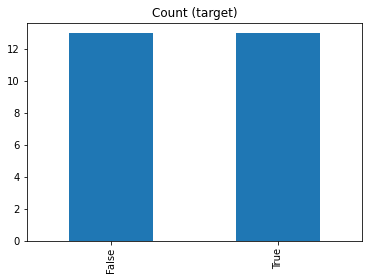

In [10]:
# Class count
count_class_0, count_class_1 = df.is_covid.value_counts()

# Divide by class
df_class_0 = df[df['is_covid'] == 0]
df_class_1 = df[df['is_covid'] == 1]

# Random under-sampling
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.is_covid.value_counts())

df_test_under.is_covid.value_counts().plot(kind='bar', title='Count (target)');